In [ ]:
!pip install import-ipynb

In [89]:
import import_ipynb
import time
%run PathPlanning.ipynb
%run localisation.ipynb
%run local_navigation_final.ipynb
%run follow_road.py
%run path_following.ipynb

# Global navigation functions
those function are only temporary and used to test the well functioning of the state machine

In [51]:
def get_angle_goal_thymio(tm_pos,tm_orient, goal_pos):
    """
    This function computes the angle between the direction the Thymio should point and the orientation of the robot 
    in order to be aligned with the goal
    
    Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               
    Return   : computed angle in range [-pi;pi]
    """
    
    #we start by computing the direction of the vector connecting the pose of the robot and the goal
    alpha = math.atan2(goal_pos[1]-tm_pos[1], goal_pos[0]-tm_pos[0])
    if alpha < 0:
        alpha += 2*math.pi
    
    theta = tm_orient-alpha
    
    if theta > math.pi:
        theta -= 2*math.pi
    if theta < -math.pi:
        theta += 2*math.pi

    return theta

In [52]:
angle_I_error = 0
def angle_PI(tm_pos, tm_orient, goal_pos, reset):
    """
        This function calulates the PI term related to the orientation of the robot to orient the robot to face the goal
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment to add/substract to the motors
    """
    #precision factor by which we first multiply the errors to gain in precision as the speed has to be an integer 
    #and truncation may affect the results
    PRECISION_FACTOR = 100
    max_error_sum = 1
    min_dist_to_goal = 10 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    #we want to saturate the speed so we have a trapezoidal speed profile for smoothness of movement
    max_speed = 80
    Kp = 80
    Ki = 5
    
    global angle_I_error
    
    if reset:
        angle_I_error = 0
    
    #checking if we are on the gaol pos
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    
    if dist < min_dist_to_goal:
        return 0
    
    error = get_angle_goal_thymio(tm_pos, tm_orient, goal_pos)
    #print("error")
    #print(error)
    angle_I_error += error
    
     #antireset windup
    if angle_I_error > max_error_sum:
        angle_I_error = max_error_sum
        
    if angle_I_error < -max_error_sum:
        angle_I_error = -max_error_sum
    
    #print("int error")
    #print(angle_I_error)
    
    speed_angle = int(((Kp*error+Ki*angle_I_error)))
    #print("speed_angle")
    #print(speed_angle)
    
    if speed_angle > max_speed:
        speed_angle = max_speed
    if speed_angle < -max_speed:
        speed_amgle = -max_speed
    
    return speed_angle

In [53]:
dist_error_sum = 0
def distance_PI(tm_pos, tm_orient, goal_pos, reset):
    """
      This function returns the speed associated to the displacement of the robot so that it reaches the goal position
        
    
    Arguments: Arguments: th_pos:    position of the Thymio 
               th_orient: orientation of the robot
               goal_pos:  [X,y] coordinates of the goal
               reset   : bool True if we want to reset the Integral error sum
    
    Return   : Speed increment add to both motors
    """
    Max_dist_error = 20
    SCALING_FACTOR = 10
    max_speed = 150 #doesn't allow a speed larger than this value so that the dynamic is homogenous (speed doesn't linearly
                    #decrease until we are close to the goal)
    
    min_dist_to_goal = 0 #if we are next to the goal of 1 cm we do not update as we consider we are on the goal
    
    global dist_error_sum
    
    if reset:
        dist_error_sum = 0
        
    dispacement_speed = 0
    Kp = 20
    Ki = 4
    
    #compute the distance
    
    dist = math.sqrt((tm_pos[0]-goal_pos[0])**2+(tm_pos[1]-goal_pos[1])**2)
    if dist <  min_dist_to_goal:
        dist = 0
    
    #if the Thymio orientation is too far from facing the goal, we first reorient the robot until it faces the goal => 
    #no displacement speed
    Phi = get_angle_goal_thymio(tm_pos,tm_orient, goal_pos)
    if Phi> math.pi/2 or Phi <-math.pi/2:
        displacement_speed = 0
    else:
        dist_error_sum += dist
        
        #antireset windup
        if dist_error_sum > Max_dist_error:
            dist_error_sum = Max_dist_error
        if dist_error_sum < -Max_dist_error:
            dist_error_sum = -Max_dist_error
        
        displacement_speed = int((dist*Kp+Ki*dist_error_sum)//SCALING_FACTOR)
        
        #saturates the speed if needed
        if displacement_speed > max_speed:
            displacement_speed = max_speed
        if displacement_speed < -max_speed:
            displacement_speed = -max_speed
    
    return displacement_speed
    

# Main
This is the core part of the code calling all the apropriate functions

In [54]:
import tdmclient.notebook
await tdmclient.notebook.start()

[205, 559]
GLOBAL
error
-0.4729682445430827
e_diff
-4.729682445430827
e_int -0.4729682445430827
speeds
[234, 99]
t1
1639156339.278961
t2
1639156339.395964
	Default values are used instead.
[205, 559]
error
-0.4767112280670023
e_diff
-0.03742983523919552
e_int -0.949679472610085
speeds
[235, 98]
t1
1639156339.4348118
t2
1639156339.5563126
	Default values are used instead.
[205, 559]
error
-0.3894179459259657
e_diff
0.872932821410366
e_int -1.3390974185360507
speeds
[222, 109]
t1
1639156339.581445
t2
1639156339.7047057
	Default values are used instead.
[205, 559]
error
-0.3298757173097815
e_diff
0.5954222861618419
e_int -1.6689731358458322
speeds
[213, 117]
t1
1639156339.7487311
t2
1639156339.868418
	Default values are used instead.
[205, 559]
error
-0.27786698826770073
e_diff
0.5200872904208076
e_int -1.946840124113533
speeds
[204, 123]
t1
1639156339.914922
t2
1639156340.0373409
	Default values are used instead.
[205, 559]
error
-0.22620979924170492
e_diff
0.5165718902599581
e_int -2.17

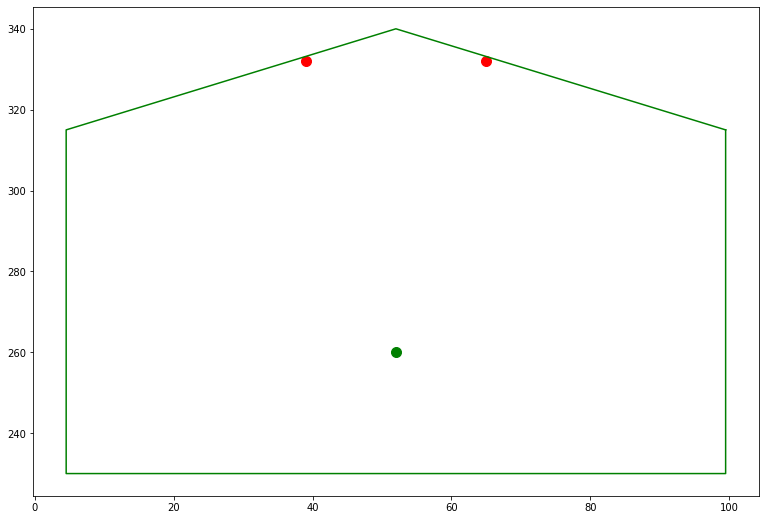

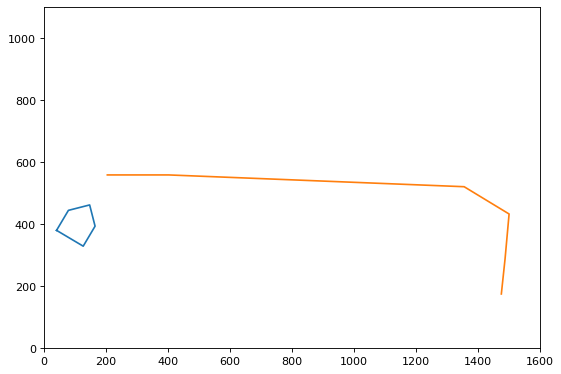

[205, 559]
error
0.0019687156535057593
e_diff
0.06746456260483757
e_int -3.007139834439535
speeds
[149, 146]
t1
1639156344.8769748
t2
1639156345.0265827
	Default values are used instead.
[205, 559]
error
0.014536803436080437
e_diff
0.12568087782574677
e_int -2.9926030310034544
speeds
[146, 147]
t1
1639156345.0578244
t2
1639156345.191534
	Default values are used instead.
[205, 559]
error
0.01638882863040969
e_diff
0.018520251943292543
e_int -2.9762142023730447
speeds
[145, 146]
t1
1639156345.2299206
t2
1639156345.35301
	Default values are used instead.
[205, 559]
error
0.01660337134688894
e_diff
0.0021454271647924905
e_int -2.959610831026156
speeds
[144, 145]
t1
1639156345.3838928
t2
1639156345.5030675
	Default values are used instead.
[205, 559]
error
0.01736808286046232
e_diff
0.007647115135733795
e_int -2.9422427481656936
speeds
[143, 145]
t1
1639156345.5371935
t2
1639156345.665064
	Default values are used instead.
[205, 559]
error
0.013761576082624627
e_diff
-0.036065067778376925
e_

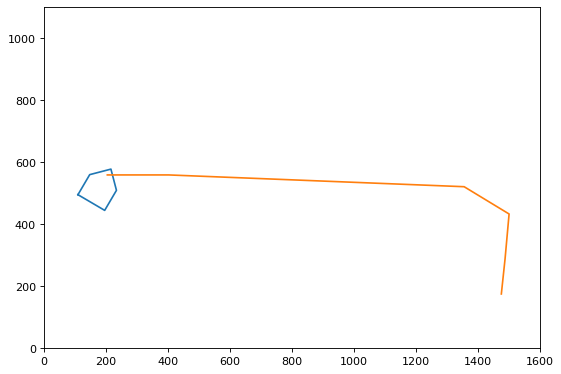

[205, 559]
error
0.01007320172753201
e_diff
0.014276955884313658
e_int -2.781274433027752
speeds
[131, 131]
t1
1639156348.177943
t2
1639156348.2941535
	Default values are used instead.
[205, 559]
error
0.013012984998791
e_diff
0.02939783271258989
e_int -2.7682614480289613
speeds
[130, 131]
t1
1639156348.3426356
t2
1639156348.4468942
	Default values are used instead.
[205, 559]
error
0.01229918465346036
e_diff
-0.007138003453306396
e_int -2.755962263375501
speeds
[130, 130]
t1
1639156348.4843144
t2
1639156348.6161773
	Default values are used instead.
[205, 559]
idx
1
error
-0.899476627787689
e_diff
-9.117758124411493
e_int -3.65543889116319
speeds
[282, 21]
t1
1639156348.6590145
t2
1639156348.7638764
	Default values are used instead.
[403, 559]
error
-0.9175437035487188
e_diff
-0.18067075761029838
e_int -4.572982594711909
speeds
[285, 18]
t1
1639156348.7929375
t2
1639156348.9060566
	Default values are used instead.
[403, 559]
error
-0.9158842298153036
e_diff
0.0165947373341524
e_int -5


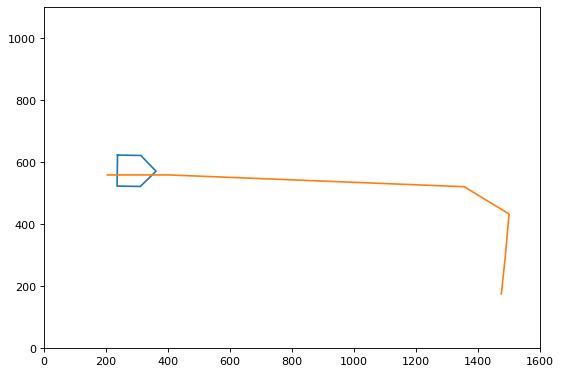

[403, 559]
error
-0.09817432793703773
e_diff
0.21556468080493205
e_int -5
speeds
[156, 122]
t1
1639156351.7239127
t2
1639156351.8399074
	Default values are used instead.
[403, 559]
error
-0.08309282587577727
e_diff
0.15081502061260466
e_int -5
speeds
[153, 123]
t1
1639156351.8916633
t2
1639156351.9995005
	Default values are used instead.
[403, 559]
error
-0.07565138402786964
e_diff
0.07441441847907626
e_int -5
speeds
[151, 124]
t1
1639156352.0405667
t2
1639156352.1597323
	Default values are used instead.
[403, 559]
error
-0.059523462551302586
e_diff
0.16127921476567053
e_int -5
speeds
[148, 125]
t1
1639156352.2067277
t2
1639156352.3242185
	Default values are used instead.
[403, 559]
error
-0.04495070054906325
e_diff
0.14572762002239337
e_int -5
speeds
[145, 127]
t1
1639156352.3407457
t2
1639156352.4657815
	Default values are used instead.
[403, 559]
error
-0.037476109528965296
e_diff
0.07474591020097954
e_int -5
speeds
[143, 127]
t1
1639156352.5236173
t2
1639156352.6382446
	Default val

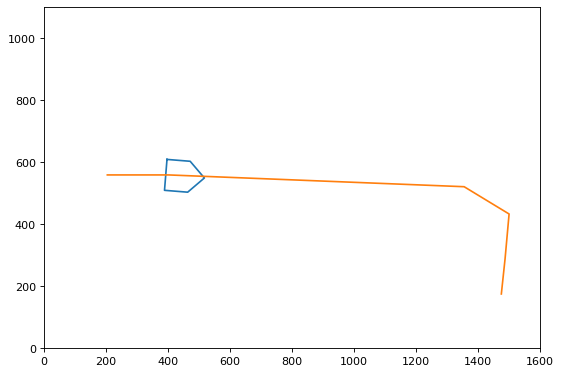

[1356, 521]
error
0.04279097404903531
e_diff
-0.09348104880676722
e_int -4.3703350434731885
speeds
[235, 242]
t1
1639156355.1367881
t2
1639156355.2526832
	Default values are used instead.
[1356, 521]
error
0.01988481681317733
e_diff
-0.22906157235857982
e_int -4.350450226660011
speeds
[237, 238]
t1
1639156355.3025815
t2
1639156355.4075131
	Default values are used instead.
[1356, 521]
error
0.0210112022813016
e_diff
0.011263854681242691
e_int -4.3294390243787095
speeds
[236, 236]
t1
1639156355.4484582
t2
1639156355.5695457
	Default values are used instead.
[1356, 521]
error
0.008779655568813993
e_diff
-0.12231546712487606
e_int -4.3206593688098955
speeds
[236, 233]
t1
1639156355.6143947
t2
1639156355.7228098
	Default values are used instead.
[1356, 521]
error
0.00375099687932412
e_diff
-0.05028658689489873
e_int -4.316908371930571
speeds
[235, 231]
t1
1639156355.7717125
t2
1639156355.8823524
	Default values are used instead.
[1356, 521]
error
0.010935424918744552
e_diff
0.07184428039420

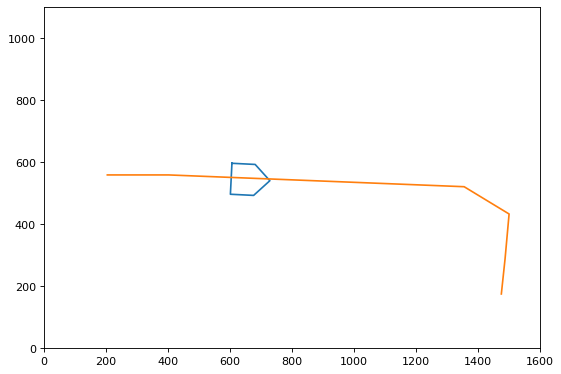

[1356, 521]
error
0.016632837254356048
e_diff
-0.016119055396108806
e_int -4.044192735822704
speeds
[212, 212]
t1
1639156358.5118163
t2
1639156358.6267815
	Default values are used instead.
[1356, 521]
error
0.01637403882745847
e_diff
-0.0025879842689757737
e_int -4.027818696995245
speeds
[211, 211]
t1
1639156358.674342
t2
1639156358.7850542
	Default values are used instead.
[1356, 521]
error
0.01851263658431268
e_diff
0.021385977568542103
e_int -4.009306060410933
speeds
[210, 210]
t1
1639156358.8125966
t2
1639156358.9317346
	Default values are used instead.
[1356, 521]
error
0.022395829647303245
e_diff
0.03883193062990564
e_int -3.9869102307636295
speeds
[208, 209]
t1
1639156358.9605827
t2
1639156359.0743074
	Default values are used instead.
[1356, 521]
error
0.027621337870789908
e_diff
0.052255082234866634
e_int -3.9592888928928396
speeds
[206, 209]
t1
1639156359.111422
t2
1639156359.221318
	Default values are used instead.
[1356, 521]
error
0.028021663225218596
e_diff
0.0040032535442

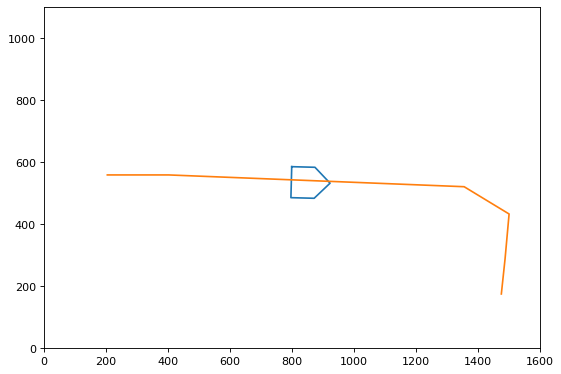

[1356, 521]
error
1.8374809216403776e-05
e_diff
-0.06074092950346888
e_int -3.6274480579934645
speeds
[190, 186]
t1
1639156362.0365949
t2
1639156362.17212
	Default values are used instead.
[1356, 521]
error
-0.013444794170184515
e_diff
-0.1346316897940092
e_int -3.640892852163649
speeds
[191, 183]
t1
1639156362.2065623
t2
1639156362.3285172
	Default values are used instead.
[1356, 521]
error
-0.027388484567725545
e_diff
-0.13943690397541028
e_int -3.6682813367313747
speeds
[192, 179]
t1
1639156362.3692703
t2
1639156362.5063493
	Default values are used instead.
[1356, 521]
error
-0.038019942351949956
e_diff
-0.10631457784224412
e_int -3.7063012790833247
speeds
[192, 177]
t1
1639156362.552836
t2
1639156362.6656609
	Default values are used instead.
[1356, 521]
error
-0.046948436857999154
e_diff
-0.08928494506049198
e_int -3.753249715941324
speeds
[192, 174]
t1
1639156362.721671
t2
1639156362.8272936
	Default values are used instead.
[1356, 521]
error
-0.04732324561948158
e_diff
-0.0037480

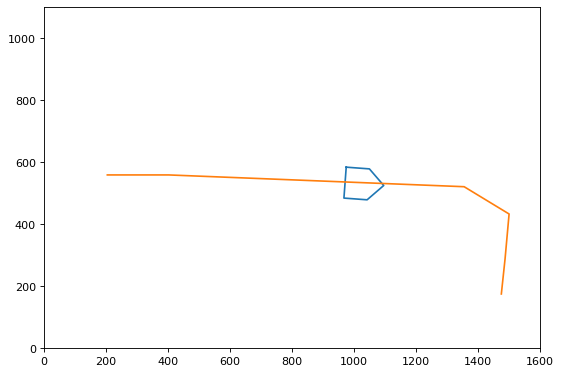

[1356, 521]
error
0.04538573966851178
e_diff
0.0007489645799108047
e_int -3.7565363825055065
speeds
[162, 171]
t1
1639156365.4860883
t2
1639156365.6074407
	Default values are used instead.
[1356, 521]
error
0.04240196553790998
e_diff
-0.029837741306018017
e_int -3.7141344169675965
speeds
[161, 169]
t1
1639156365.6398947
t2
1639156365.760025
	Default values are used instead.
[1356, 521]
error
0.030551236164455986
e_diff
-0.11850729373453994
e_int -3.6835831808031405
speeds
[162, 166]
t1
1639156365.8069944
t2
1639156365.922357
	Default values are used instead.
[1356, 521]
error
0.03776746234383044
e_diff
0.07216226179374452
e_int -3.64581571845931
speeds
[160, 166]
t1
1639156365.9740915
t2
1639156366.094047
	Default values are used instead.
[1356, 521]
error
0.04025987929921193
e_diff
0.024924169553814934
e_int -3.605555839160098
speeds
[159, 166]
t1
1639156366.1497498
t2
1639156366.2750258
	Default values are used instead.
[1356, 521]
error
0.03431262314665773
e_diff
-0.0594725615255420

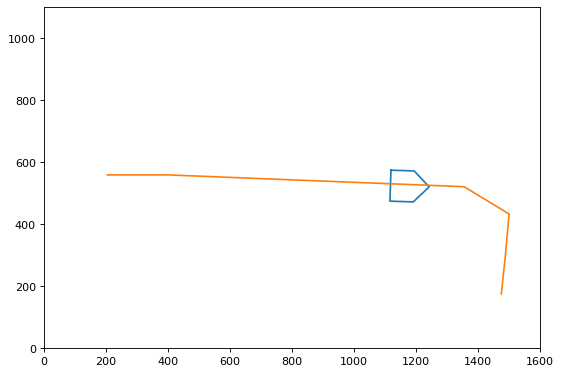

[1356, 521]
error
0.022502959266154754
e_diff
-0.03803905813296815
e_int -3.1045342206215003
speeds
[147, 149]
t1
1639156368.8318996
t2
1639156368.9501057
	Default values are used instead.
[1356, 521]
error
0.02027316353834241
e_diff
-0.022297957278123448
e_int -3.084261057083158
speeds
[146, 148]
t1
1639156368.9832015
t2
1639156369.0916348
	Default values are used instead.
[1356, 521]
error
0.018177990374472763
e_diff
-0.020951731638696458
e_int -3.066083066708685
speeds
[146, 147]
t1
1639156369.1201997
t2
1639156369.2319613
	Default values are used instead.
[1356, 521]
error
0.019400991127027645
e_diff
0.012230007525548814
e_int -3.0466820755816575
speeds
[145, 146]
t1
1639156369.289817
t2
1639156369.4136908
	Default values are used instead.
[1356, 521]
error
0.02028962843797011
e_diff
0.008886373109424639
e_int -3.0263924471436874
speeds
[143, 146]
t1
1639156369.44876
t2
1639156369.5689092
	Default values are used instead.
[1356, 521]
error
0.01965938550476043
e_diff
-0.006302429332

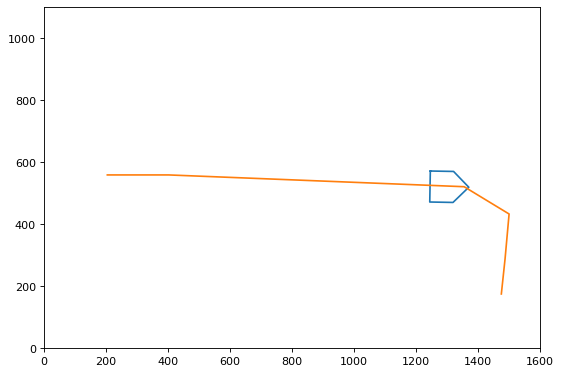

[1356, 521]
error
0.023189383499664373
e_diff
0.043510926634624525
e_int -2.8495697835871963
speeds
[130, 134]
t1
1639156371.971775
t2
1639156372.0968819
	Default values are used instead.
[1356, 521]
error
0.02494669412907502
e_diff
0.017573106294106466
e_int -2.8246230894581212
speeds
[129, 133]
t1
1639156372.1293292
t2
1639156372.2539904
	Default values are used instead.
[1356, 521]
error
0.035478134111998294
e_diff
0.10531439982923274
e_int -2.789144955346123
speeds
[127, 134]
t1
1639156372.27109
t2
1639156372.3752513
	Default values are used instead.
[1356, 521]
error
0.04570695393252944
e_diff
0.10228819820531143
e_int -2.7434380014135935
speeds
[125, 134]
t1
1639156372.412656
t2
1639156372.5300405
	Default values are used instead.
[1356, 521]
idx
3
error
-0.42963621722718504
e_diff
-4.753431711597145
e_int -3.1730742186407785
speeds
[213, 86]
t1
1639156372.597984
t2
1639156372.720388
	Default values are used instead.
[1501, 433]
error
-0.43888169608215577
e_diff
-0.09245478854970

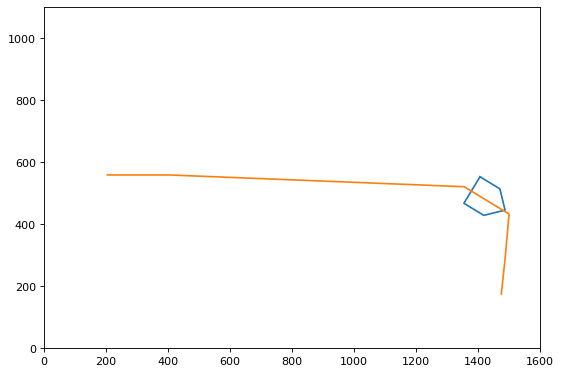

[1501, 433]
error
-0.042110208167394525
e_diff
0.09211094545158893
e_int -5
speeds
[145, 127]
t1
1639156375.4478972
t2
1639156375.5779798
	Default values are used instead.
[1501, 433]
error
-0.03105760928938217
e_diff
0.11052598878012354
e_int -5
speeds
[143, 128]
t1
1639156375.6238003
t2
1639156375.7404804
	Default values are used instead.
[1501, 433]
error
-0.017919175214101024
e_diff
0.13138434075281147
e_int -5
speeds
[140, 129]
t1
1639156375.7766633
t2
1639156375.8912933
	Default values are used instead.
[1501, 433]
error
-0.01082091434245136
e_diff
0.07098260871649664
e_int -5
speeds
[138, 129]
t1
1639156375.953665
t2
1639156376.0594413
	Default values are used instead.
[1501, 433]
error
-0.008951122563750857
e_diff
0.018697917787005025
e_int -5
speeds
[137, 129]
t1
1639156376.108785
t2
1639156376.219416
	Default values are used instead.
[1501, 433]
error
-0.005864369302291728
e_diff
0.030867532614591298
e_int -5
speeds
[136, 128]
t1
1639156376.2699556
t2
1639156376.3922262
	Defa

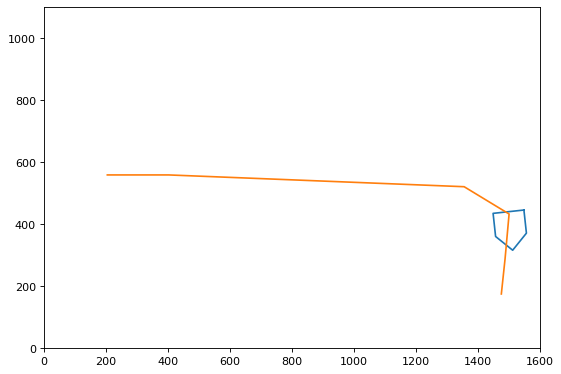

[1488, 288]
error
-0.2672889876900655
e_diff
0.19883623363138092
e_int -5
speeds
[179, 96]
t1
1639156378.9515653
t2
1639156379.0762165
	Default values are used instead.
[1488, 288]
error
-0.24359967861864096
e_diff
0.23689309071424525
e_int -5
speeds
[174, 99]
t1
1639156379.1245883
t2
1639156379.2416437
	Default values are used instead.
[1488, 288]
error
-0.22444506769185413
e_diff
0.1915461092678683
e_int -5
speeds
[171, 101]
t1
1639156379.2967026
t2
1639156379.4135394
	Default values are used instead.
[1488, 288]
error
-0.1985705435030507
e_diff
0.25874524188803427
e_int -5
speeds
[166, 104]
t1
1639156379.470098
t2
1639156379.5924363
	Default values are used instead.
[1488, 288]
error
-0.16912798786119865
e_diff
0.29442555641852053
e_int -5
speeds
[161, 107]
t1
1639156379.640343
t2
1639156379.758043
	Default values are used instead.
[1488, 288]
error
-0.15090465366645311
e_diff
0.18223334194745533
e_int -5
speeds
[158, 109]
t1
1639156379.8089814
t2
1639156379.933069
	Default values a

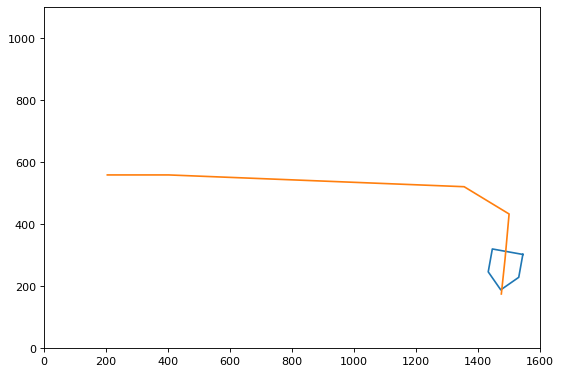

[1476, 175]
error
0.04801967088521497
e_diff
0.009516946674388294
e_int -4.434574042359445
speeds
[131, 140]
t1
1639156382.4591212
t2
1639156382.5795395
	Default values are used instead.
	Continuing as if the map was a torus.
[1476, 175]
error
0.051002563884710916
e_diff
0.029828929994959452
e_int -4.383571478474734
speeds
[130, 139]
t1
1639156382.6275988
t2
1639156382.7321007
	Default values are used instead.
	Continuing as if the map was a torus.
[1476, 175]
error
0.05224978741883124
e_diff
0.01247223534120323
e_int -4.331321691055903
speeds
[129, 139]
t1
1639156382.7862513
t2
1639156382.9125764
	Default values are used instead.
	Continuing as if the map was a torus.
[1476, 175]
error
0.050158158467862535
e_diff
-0.020916289509687047
e_int -4.281163532588041
speeds
[128, 138]
t1
1639156382.9623685
t2
1639156383.0969758
	Default values are used instead.
	Continuing as if the map was a torus.
[1476, 175]
error
0.05458393303279685
e_diff
0.04425774564934315
e_int -4.226579599555244
spee

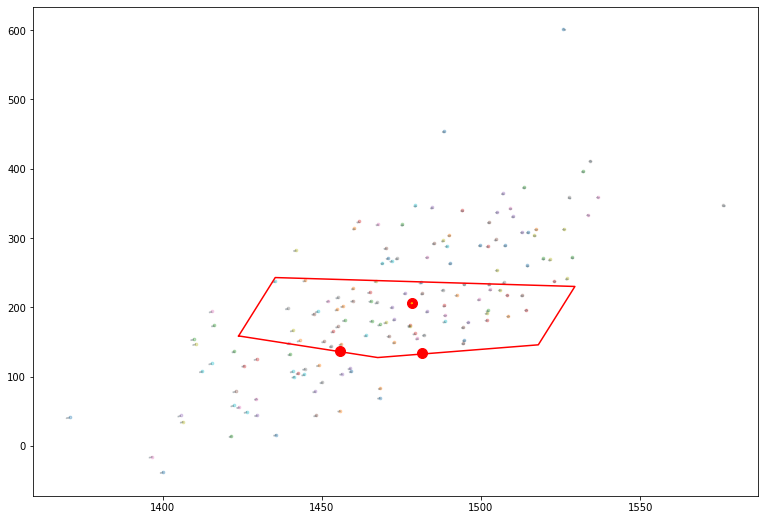

In [90]:
#putting everything together
#putting together functions
obstacle = False
motor_left_target = 0
motor_right_target = 0
ITER_PATH_FREE = 9 #number of iteration where the path to the goal is free before we stop following the obstacle
dist_thresh = 20
#States of the robot
STATE_GLOBAL_NAV = 0
STATE_LOCAL_NAV = 1

#Threshold for obstacle detection
THRESHOLD_PROX1 = 1700
THRESHOLD_PROX2 = 1500
THRESHOLD_PROX3 = 1500
THRESHOLD_PROX0 = 2000
THRESHOLD_PROX4 = 2000

#refresh period
dt = 0.1

#initliasie the pose of the robot
pose = Pose(52, 260,math.pi/2,nb_particles = 150) #Pose(0, 0,0,nb_particles = 150) #Pose(52, 260,math.pi/2,nb_particles = 150) #Pose(0, 0,0,nb_particles = 150)
##pose.set_coords(500, 500, math.pi/2)

robot_state = STATE_GLOBAL_NAV

#objective
goals = [[205,559],[403,559],[1356,521],[1501,433],[1488,288],[1476,175]]
coords = pose.get_coords()


#initialize variable for the loop
go_left = True
reset_glob_regulator = True
reset_local_regulator = True
speeds_robot = [0, 0]
obstacle = False
#plot_counter = 0

#counters used to determine if we must reset the PID controllers (integrator terms and derivatives)
local_nav_iter = 1
global_nav_iter = 1
#for local navigation counts how many consecutive iteration the path is free (used to go back to global nav)
free_path_iter = 0 
pose.plot(plot_theta = False)
goal_idx = 0
goal = goals[goal_idx]

dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
t1 = time.time()
pos_plot_ite = 0
while dist_to_goal > dist_thresh and goal_idx <= len(goals)-1:
    t1 = time.time()
    if dist_to_goal<dist_thresh*2:
        goal_idx+=1

        print(goal_idx)
        if goal_idx <= len(goals)-1:
            goal = goals[goal_idx]
        
    
    if robot_state == STATE_GLOBAL_NAV:
        
        
        if global_nav_iter > 1:
            reset_glob_regulator = False
        else:
            print("GLOBAL")
            leds_circle[3] = 25
            leds_circle[1] = 0
            leds_circle[2] = 0

        global_nav_iter += 1
        
        prox = prox_horizontal
    
        obstacle = obstacle or obstacle_detected(prox[2], THRESHOLD_PROX2)
        obstacle = obstacle or obstacle_detected(prox[1], THRESHOLD_PROX1)
        obstacle = obstacle or obstacle_detected(prox[3], THRESHOLD_PROX3)
        obstacle = obstacle or obstacle_detected(prox[0], THRESHOLD_PROX0)
        obstacle = obstacle or obstacle_detected(prox[4], THRESHOLD_PROX4)
        if obstacle:
            leds_circle[2] = 25
        
        
        #speed_theta = angle_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        #speed_disp = distance_PI([coords['x'],coords['y']], coords['theta'], goal, reset_glob_regulator)
        #speeds_robot = [speed_theta+speed_disp,speed_disp-speed_theta]
        speeds_robot = follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_theta+speed_disp,speed_disp-speed_theta]
        #follow_path([coords['x'],coords['y'],coords['theta']],goal,reset_glob_regulator,dt) #[speed_disp+speed_theta, speed_disp-speed_theta]
        
        if obstacle:
            robot_state = STATE_LOCAL_NAV
            coords = pose.get_coords()
            Go_left = choose_direction(prox, goal, (coords['x'],coords['y']), coords['theta'])
            #print("Go_left")
            #print(Go_left)
            print("IN OBSTCLE")
            reset_local_regulator = True
            local_nav_iter = 1
            free_path_iter = 0
            
            
    elif robot_state == STATE_LOCAL_NAV:
        
        prox = prox_horizontal
        
        if local_nav_iter > 1:
            reset_local_regulator = False
        else:
            print("LOCAL")
            leds_circle[3] = 0
            leds_circle[1] = 25

            
        local_nav_iter += 1
        
        if Go_left:
        #if turn left obstacle is on the rigth
            speeds = right_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
        
        
        else:
            speeds = left_obst_follow(reset_local_regulator)
            speeds_robot = [speeds[1], speeds[0]]
    
  
        coords = pose.get_coords()
    
        if path_to_goal_free(coords['theta'], (coords['x'],coords['y']), goal ,prox):
            free_path_iter += 1
            print("free path iter")
            print(free_path_iter)
            if free_path_iter > ITER_PATH_FREE:
                    robot_state = STATE_GLOBAL_NAV
                    print("PATH IS FREE")
                    global_nav_iter = 1
                    reset_glob_regulator = True
                    obstacle = False
                    
                    
        else:
            free_path_iter = 0
        
    
    motor_left_target = speeds_robot[0]
    motor_right_target = speeds_robot[1]
    
  
    sleep(dt)
    t2 = time.time()
    print("t1")
    print(t1)
    print("t2")
    print(t2)
    speeds_meas = [motor_left_speed,motor_right_speed]    
    prox_grnd = prox_ground_delta
    pose.update(speed=speeds_meas, prox=prox_grnd, dt=(t2-t1), myMap = myMap)
    
    coords = pose.get_coords()
    dist_to_goal = math.sqrt((coords['x']-goal[0])**2+(coords['y']-goal[1])**2)
    if dist_to_goal < dist_thresh and goal_idx >= len(goals):
        break
    pos_plot_ite += 1
    if pos_plot_ite == 20:
        pos_plot_ite = 0
        #pose.plot(plot_theta = False)
        draw_now([coords['x'],coords['y'],coords['theta']],goals)
    #if plot_counter == 8:
     #   plot_counter = 0
      #  pose.plot(plot_theta = False)
    #plot_counter += 1

sleep(dt)
motor_left_target = 0
motor_right_target = 0
pose.plot()


In [84]:
motor_left_target = 0
motor_right_target = 0

{'x': 672.9314130334344,
 'y': 0.481520409385151,
 'theta': -0.038278471915123395}

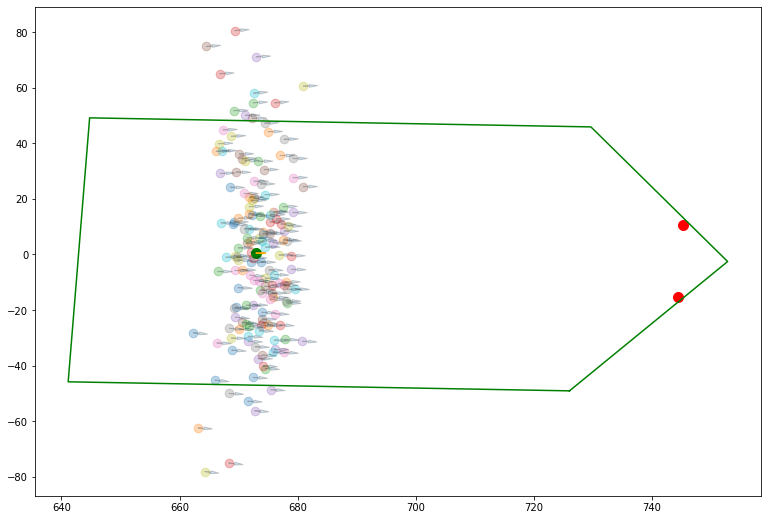

In [45]:
pose.plot()
pose.get_coords()

In [13]:
await tdmclient.notebook.stop()

In [6]:
pose = Pose(500,500,0,nb_particles = 150)
dt = 0.1

In [26]:
pose.set_coords(500, 500, 0.00)

In [27]:
pose.update([0,0], [300,230], dt, myMap)
pose.get_coords()

speed odo
[-2.50069343 -2.15336496]
dl
-0.25006934308949663
dr
-0.2153364963938476
dl-dr
-0.03473284669564902
dtheta
0.0003656089125857792
speed odo
[-2.2099481  0.1744908]
dl
-0.22099481004582128
dr
0.017449080001568935
dl-dr
-0.23844389004739022
dtheta
0.002509935684709371
speed odo
[-0.14815388  1.4067247 ]
dl
-0.014815388440390022
dr
0.14067247011820677
dl-dr
-0.1554878585585968
dtheta
0.0016367143006168082
speed odo
[4.57433344 2.64830949]
dl
0.45743334403817637
dr
0.2648309485627007
dl-dr
0.1926023954754757
dtheta
-0.0020273936365839546
speed odo
[-8.3900673  -0.69920084]
dl
-0.8390067295971575
dr
-0.06992008402964679
dl-dr
-0.7690866455675107
dtheta
0.008095648900710638
speed odo
[3.20535784 0.06104229]
dl
0.32053578438267033
dr
0.006104229103150237
dl-dr
0.3144315552795201
dtheta
-0.00330980584504758
speed odo
[-0.30450243  2.34779932]
dl
-0.03045024314558134
dr
0.23477993217082727
dl-dr
-0.2652301753164086
dtheta
0.0027918965822779853
speed odo
[ 2.38232498 -1.75367234]
dl
0.2

{'x': 901.6380013365394, 'y': 276.8832618901886, 'theta': 5.776116264541707}

In [24]:
math.atan2((500.000125914653-500),(499.9525965798133-500))

3.138936424221645

1639154519.9076345
1639154520.9101963
-1.0025618076324463
